# Position Clustering

Take out the coordinates for all the players in the games and then scatter them on a football field

Then develop 9 different clusters for the different player posistions

In [57]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
import plotly.express as px
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import squarify
import plotly.express as px
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_63686/598650177.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


In [58]:
# Constants
EVENT_NO = 400
CLUSTER_NO = 8

In [59]:
# Load the data
df_damallsvenskan_org = pd.read_csv('csv/damallsvenskan_all.csv')
df_allsvenskan_org = pd.read_csv('csv/allsvenskan_all.csv')

In [60]:
# Add a new column that counts the frequency of each player's name
df_damallsvenskan_org['name_count'] = df_damallsvenskan_org.groupby('player')['player'].transform('count')
df_allsvenskan_org['name_count'] = df_allsvenskan_org.groupby('player')['player'].transform('count')

# For each unique player, take out the mean xpos and ypos
df_damallsvenskan = df_damallsvenskan_org.groupby('player').agg({'xpos':'mean', 'ypos':'mean', 'name_count':'first'}).reset_index()
df_allsvenskan = df_allsvenskan_org.groupby('player').agg({'xpos':'mean', 'ypos':'mean', 'name_count':'first'}).reset_index()

# Put them together (UNCOMMENT IF WANT BOTH LEAGUES/ONE LEAGUE)
df = pd.concat([df_allsvenskan, df_damallsvenskan])
#df = df_allsvenskan

# Scale the xpos and ypos for every player
df['xpos'] = (df['xpos'] * 120) / 100
df['ypos'] = (df['ypos'] * 80) / 100

In [61]:
# Remove all the players that have a namecount of less than EVENT_NO and place all those players in another df
df2 = df[df['name_count'] < EVENT_NO]
df = df[df['name_count'] >= EVENT_NO]

# print the amount of rows for both dataframes
print('Dataframe1: ' + str(len(df)))
print('Dataframe2: ' + str(len(df2)))

df2

Dataframe1: 1260
Dataframe2: 386


,player,xpos,ypos,name_count
0,A. Ademi,86.275229,52.413456,327
9,A. Aliev,75.493194,36.381152,382
12,A. Angelin,52.146939,70.476190,147
14,A. Bahtijar,46.628571,36.914286,7
15,A. Bark,66.600000,48.933333,6
...,...,...,...,...
632,T. Uppfeld,82.800000,20.000000,4
635,V. Andersson,53.230769,29.271795,78
641,V. Persbeck,22.350000,62.800000,24
646,W. Heatley,37.022841,67.413928,359


In [62]:
# Create a new column called 'position' and set it to nan
df['position'] = np.nan

# Set all players win xpos<30 to GK
df.loc[df['xpos'] < 32, 'position'] = 'GK'

# Put all the GK in a new dataframe
df_gk = df[df['position'] == 'GK']
df = df[df['position'] != 'GK']

/var/folders/yn/w3h701111q199y7qdtvn61940000gn/T/ipykernel_63686/3964150314.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'GK' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['xpos'] < 32, 'position'] = 'GK'


In [63]:
# Print how mant of the players have y>40 and y<40
print('Players with y>40: ' + str(len(df[df['ypos'] > 40])))
print('Players with y<40: ' + str(len(df[df['ypos'] < 40])))

Players with y>40: 560
Players with y<40: 608


In [64]:
# Take out all the xpos and ypos
x_pos = df['xpos']
y_pos = df['ypos']

x_pos2 = df2['xpos']
y_pos2 = df2['ypos']

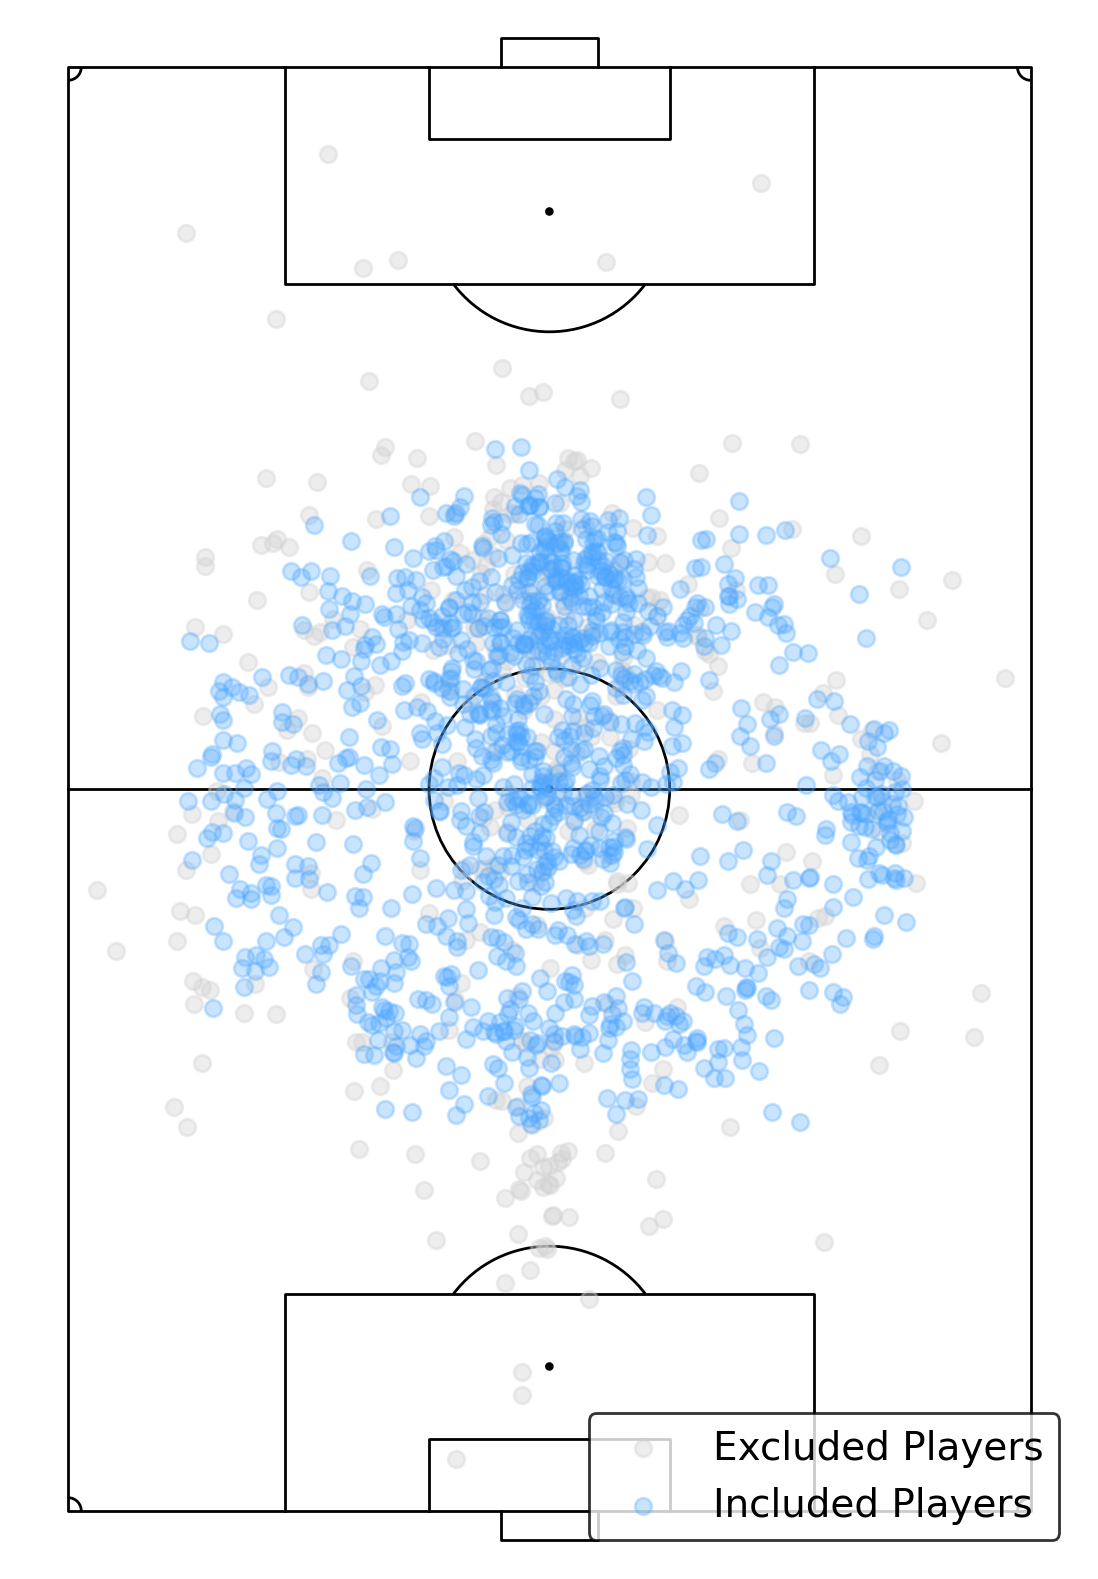

In [65]:
# Plot on a pitch with a heatmap of the scatters 
pitch = VerticalPitch(half=False, goal_type='box', corner_arcs=True, pitch_color='white', line_color='black', linewidth=1)
fig, ax = pitch.draw(figsize=(8,8))

# Scatter
pitch.scatter(x_pos2, y_pos2, ax=ax, color='lightgrey', alpha=0.4, label='Excluded Players')
pitch.scatter(x_pos, y_pos, ax=ax, color='#4da6ff', alpha=0.3, label='Included Players')

# Create a legend and set the facecolor, edgecolor, and fontsize
legend = ax.legend(loc='lower right', facecolor='white', edgecolor='black', fontsize=14)

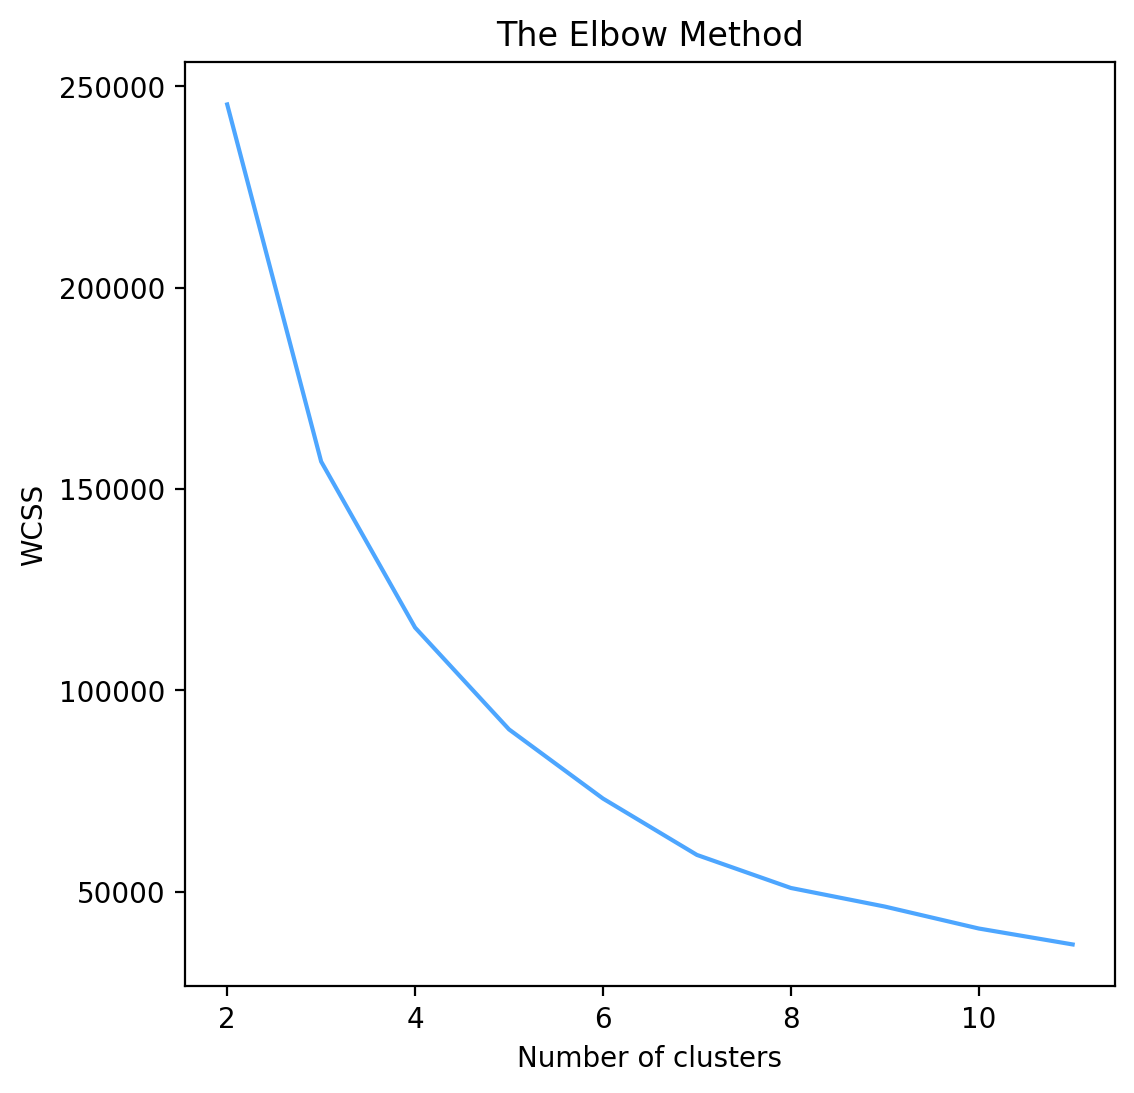

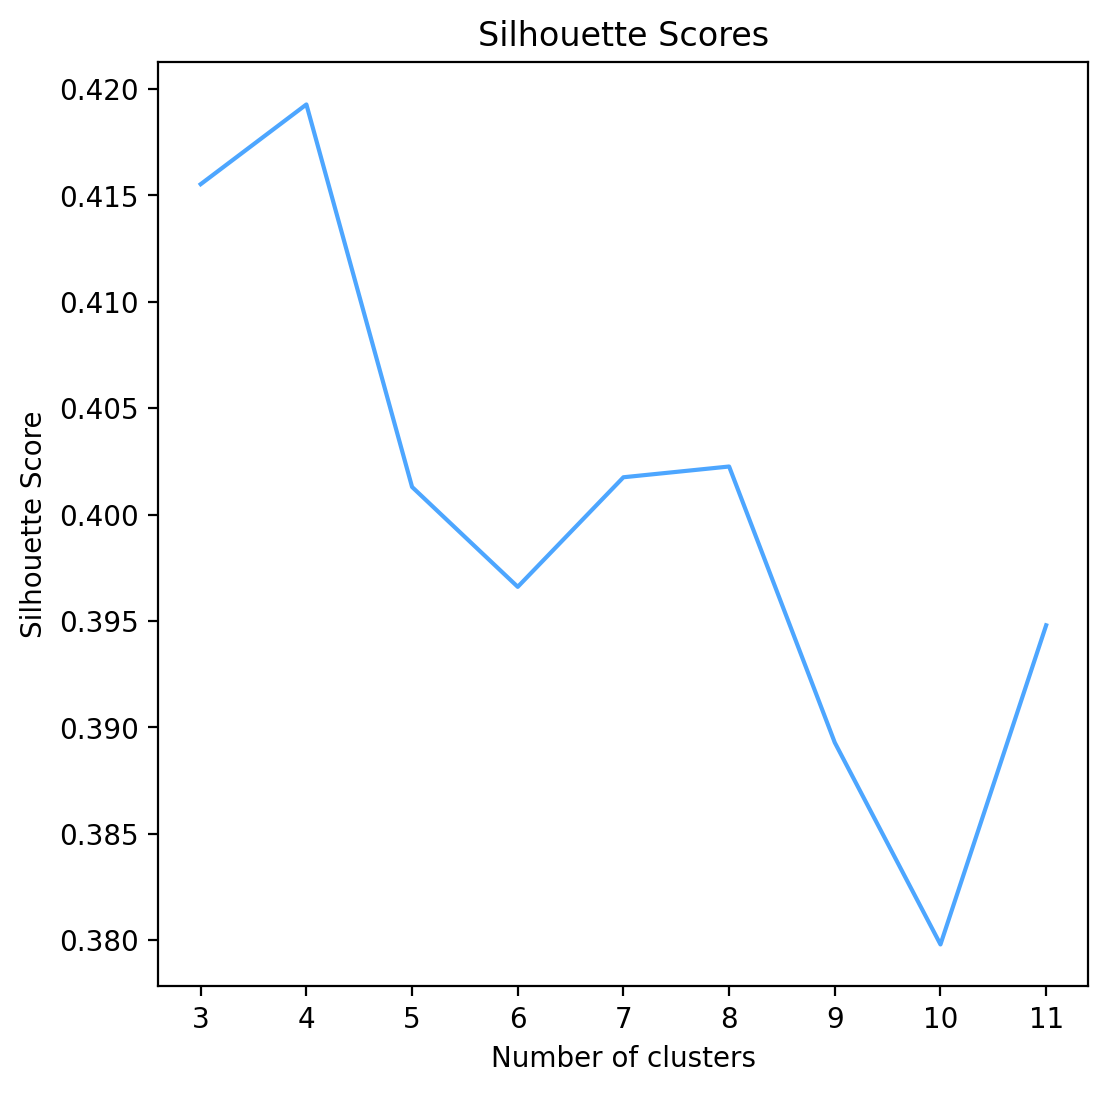

[0.41553127301367526, 0.4192785876967911, 0.40130140304551276, 0.3966076929269943, 0.40175775308820877, 0.40226301084175475, 0.389288618139914, 0.3798021132345061, 0.39480099340458846]


In [66]:
data = list(zip(x_pos, y_pos))

# List to hold the values of WCSS (Within-Cluster Sum of Square)
wcss = []

# List to hold the values of Silhouette Score
sil_scores = []

# Range of possible cluster numbers
cluster_range = range(2, 12)

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data)
    wcss.append(kmeans.inertia_)
    if i > 2:  # Silhouette Score requires at least 2 clusters
        sil_scores.append(silhouette_score(data, kmeans.labels_))

# Plotting the results onto a line graph to observe 'The elbow'
plt.figure(figsize=(6,6))
plt.plot(cluster_range, wcss, color='#4da6ff')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

# Plotting the Silhouette Scores
plt.figure(figsize=(6,6))
plt.plot(cluster_range[1:], sil_scores, color='#4da6ff')
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

#print the silhouette scores
print(sil_scores)

Text(39.475096327855454, 27.58442473764833, 'GK')

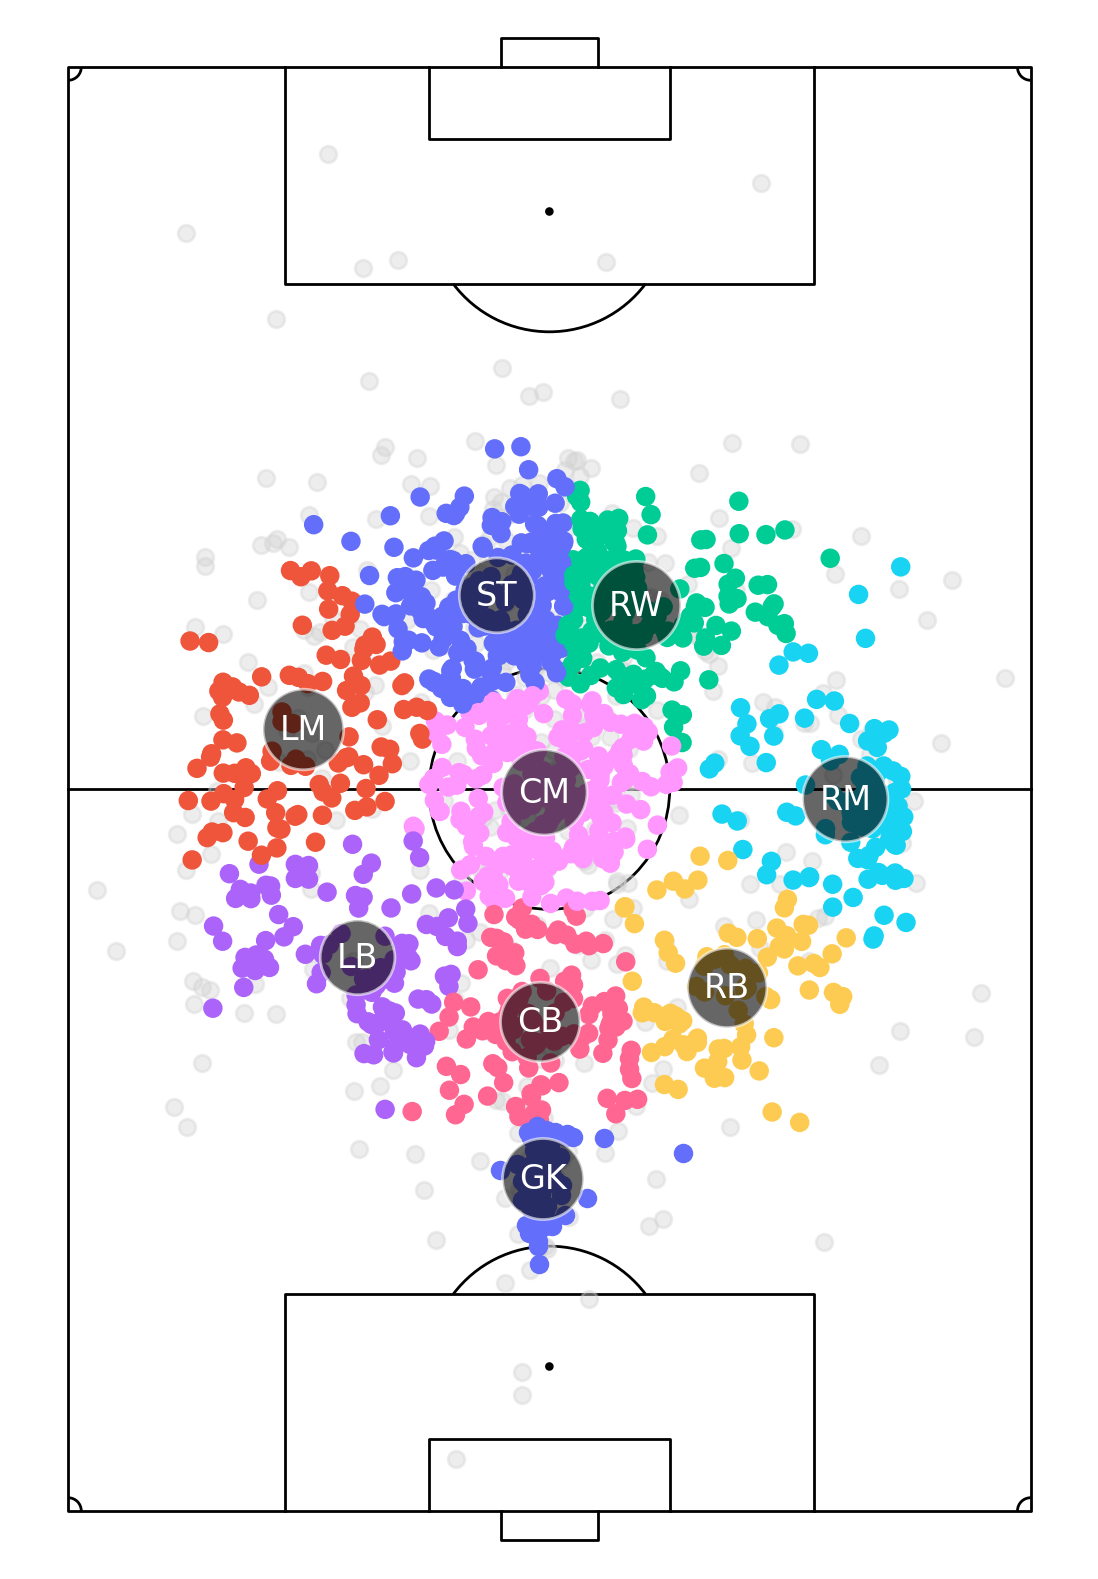

In [67]:
# First, perform KMeans clustering
kmeans = KMeans(n_clusters=CLUSTER_NO)
kmeans.fit(data)

# Define the positions
positions = ['ST', 'LM', 'RW', 'LB', 'LW', 'RM', 'CB', 'X', 'CM', 'RB', 'GK']

# Create a colormap from ploty
cmap = px.colors.qualitative.Plotly

# Create a color dictionary mapping each position to a color from the colormap
color_dict = {position: cmap[i % len(cmap)] for i, position in enumerate(positions)}
# Assuming data is a list of tuples [(x1, y1), (x2, y2), ...]
x, y = zip(*data)

# Get cluster labels
labels = kmeans.labels_

# Get cluster centers
centers = kmeans.cluster_centers_
cx, cy = zip(*centers)

pitch = VerticalPitch(half=False, goal_type='box', corner_arcs=True, pitch_color='white', line_color='black', linewidth=1)
fig, ax = pitch.draw(figsize=(8,8))

# Scatter the players that havnt played as much
pitch.scatter(x_pos2, y_pos2, ax=ax, color='lightgrey', alpha=0.4)

annotations = {}
for i, (center_x, center_y) in enumerate(centers):
    if (center_x > 70) and (35 < center_y < 45):
        annotation = 'ST'
    elif (center_x > 70) and (center_y > 45):
        annotation = 'RW'
    elif (center_x > 70) and (center_y < 35):
        annotation = 'LW'
    elif (center_x < 50) and (35 < center_y < 45):
        annotation = 'CB'
    elif (center_x < 50) and (center_y > 45):
        annotation = 'RB'
    elif (center_x < 50) and (center_y < 35):
        annotation = 'LB'
    elif (50 < center_x < 70) and (35 < center_y < 45):
        annotation = 'CM'
    elif (50 < center_x < 70) and (center_y > 45):
        annotation = 'RM'
    elif (50 < center_x < 70) and (center_y < 35):
        annotation = 'LM'
    else:
        annotation = 'X'
    annotations[i] = annotation
    pitch.annotate(annotation, (center_x, center_y), color='white', fontsize=12, ha='center', va='center', 
                   bbox=dict(facecolor='black', edgecolor='white', boxstyle='circle', pad=0.5, alpha=0.6), ax=ax)

# Create a list of colors for each data point
colors = [color_dict[annotations[label]] for label in labels]

# Scatter the data with color labels
pitch.scatter(x, y, c=colors, ax=ax)

# Scatter the goalkeepers
pitch.scatter(df_gk['xpos'], df_gk['ypos'], ax=ax, color=color_dict['GK'], alpha=1)

# Calculate the centroid of the goalkeepers' positions
gk_centroid_x = df_gk['xpos'].mean()
gk_centroid_y = df_gk['ypos'].mean()

# Annotate the centroid of the goalkeepers' positions
pitch.annotate('GK', (gk_centroid_x, gk_centroid_y), color='white', fontsize=12, ha='center', va='center', 
               bbox=dict(facecolor='black', edgecolor='white', boxstyle='circle', pad=0.5, alpha=0.6), ax=ax)

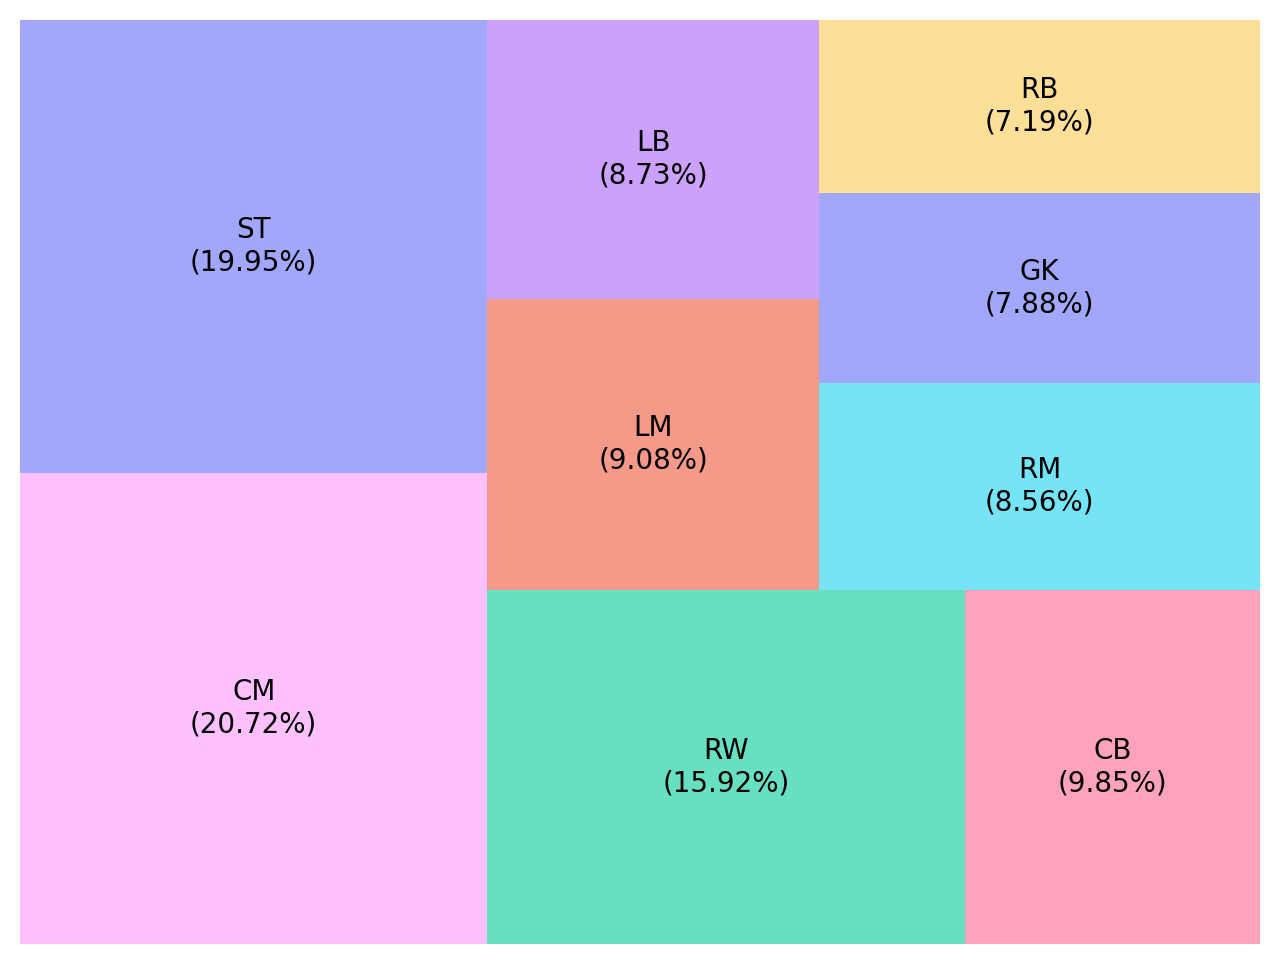

In [68]:
gk_count = len(df_gk)

cluster_percentages = []
cluster_labels = []
for i in range(CLUSTER_NO):
    cluster_percentage = round((len(labels[labels == i]) / len(labels)) * 100, 2)
    cluster_label = annotations[i]
    cluster_percentages.append(cluster_percentage)
    cluster_labels.append(cluster_label)

# Add the goalkeeper count and label
gk_percentage = round((gk_count / len(labels)) * 100, 2)
cluster_percentages.append(gk_percentage)
cluster_labels.append('GK')

# Create a DataFrame for the treemap
df_treemap = pd.DataFrame({'labels': cluster_labels, 'percentages': cluster_percentages})

# Sort the DataFrame by percentages in descending order
df_treemap.sort_values('percentages', ascending=False, inplace=True)

# Create a color list for the treemap
colors = [color_dict.get(label, 'pink') for label in df_treemap['labels']]

# Modify the labels to include the percentages
df_treemap['labels'] = df_treemap.apply(lambda row: f"{row['labels']}\n({row['percentages']}%)", axis=1)

# Create the treemap
fig, ax = plt.subplots(figsize=(8, 6))
squarify.plot(sizes=df_treemap['percentages'], label=df_treemap['labels'], color=colors, alpha=0.6, ax=ax)
plt.axis('off')
plt.show()

In [69]:
# For each the coordinates that corresponds to the players in the original df, add the cluster label
df['position'] = kmeans.labels_

# Map the cluster labels to their corresponding annotations
df['position'] = df['position'].map(annotations)

# Add the gk to the original df
df_gk['position'] = 'GK'
df = pd.concat([df, df_gk, df2])

In [70]:
# Define the roles
defender_positions = ['CB', 'RB', 'LB']
midfielder_positions = ['LM', 'RM', 'CM']
attacker_positions = ['ST', 'LW', 'RW']

# Add the 'Role' column
df['Role'] = df['position'].apply(lambda x: 'Defender' if x in defender_positions else 'Midfielder' if x in midfielder_positions else 'Attacker' if x in attacker_positions else 'Goalkeeper' if x == 'GK' else np.nan)

# Rename the columns
df.rename(columns={'player': 'Player Name', 'xpos': 'Mean X-Position', 'ypos': 'Mean Y-Position', 'name_count': 'Event Amount', 'position': 'Position'}, inplace=True)

# Sort after player name
df = df.sort_values(by='Player Name')

In [71]:
df.head(50)

,Player Name,Mean X-Position,Mean Y-Position,Event Amount,Position,Role
0,A. Abbe,56.804692,66.214663,1023,RM,Midfielder
1,A. Abdulle,103.984615,27.384615,26,NaN,NaN
0,A. Ademi,86.275229,52.413456,327,NaN,NaN
1,A. Affane,69.141195,29.982122,1857,ST,Attacker
2,A. Ahl Holmström,81.047541,39.640437,1464,ST,Attacker
2,A. Ahlberg,51.004811,38.542650,2619,CM,Midfielder
3,A. Ahlin,29.741887,39.091321,530,GK,Goalkeeper
4,A. Ahmed,66.869063,37.888981,1697,CM,Midfielder
5,A. Ahmedhodzic,43.660503,25.603461,6241,LB,Defender
6,A. Ajdarević,69.437347,43.431291,2774,RW,Attacker


In [72]:
# Sort the dataframe after event amount
df = df.sort_values(by='Event Amount', ascending=False)

# print goalkeepers
df[df['Position'] == 'RB'].head(50)

,Player Name,Mean X-Position,Mean Y-Position,Event Amount,Position,Role
653,M. Mathisen,50.109143,46.227747,14077,RB,Defender
942,V. Agardius,48.744992,61.093042,12820,RB,Defender
259,G. Viggosdottir,46.223029,54.551554,10969,RB,Defender
525,P. Boakye,47.331417,60.963387,10297,RB,Defender
552,S. Adolfsson,39.293458,52.306829,9767,RB,Defender
819,R. Lindgren,41.873054,47.840765,9415,RB,Defender
11,A. Andersson,54.417023,52.526823,8929,RB,Defender
377,H. Ekdal,45.839567,53.735827,8876,RB,Defender
194,E. Nyström,40.473907,50.809112,8692,RB,Defender
325,J. Harrysson,46.300650,63.501148,7231,RB,Defender


In [73]:
# Save the dataframe to a csv
#df.to_csv('csv/player_positions.csv', index=False)